In [1]:
#commands used

#clone to gitgub repo
#git clone https://github.com/AhmadMaraqa20/Mlflow_Dagshub.git

#mlflow ui 


#push to github repo when finished 
# git status
# git add -----
#git push

# go to dagshub and connect that repo 
#press remote then press experiments

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [3]:
data = pd.read_csv("Data_cleaned/mushroom_cleaned.csv") 
#https://www.kaggle.com/code/annastasy/mushroom-classification-simple-models-99

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54035 non-null  int64  
 1   cap-shape        54035 non-null  int64  
 2   gill-attachment  54035 non-null  int64  
 3   gill-color       54035 non-null  int64  
 4   stem-height      54035 non-null  float64
 5   stem-width       54035 non-null  int64  
 6   stem-color       54035 non-null  int64  
 7   season           54035 non-null  float64
 8   class            54035 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.7 MB


In [5]:
data.describe()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
count,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000
mean,567.257204,4.000315,2.142056,7.329509,0.759110,1051.081299,8.418062,0.952163,0.549181
std,359.883763,2.160505,2.228821,3.200266,0.650969,782.056076,3.262078,0.305594,0.497580
min,0.000000,0.000000,0.000000,0.000000,0.000426,0.000000,0.000000,0.027372,0.000000
25%,289.000000,2.000000,0.000000,5.000000,0.270997,421.000000,6.000000,0.888450,0.000000
50%,525.000000,5.000000,1.000000,8.000000,0.593295,923.000000,11.000000,0.943195,1.000000
75%,781.000000,6.000000,4.000000,10.000000,1.054858,1523.000000,11.000000,0.943195,1.000000
max,1891.000000,6.000000,6.000000,11.000000,3.835320,3569.000000,12.000000,1.804273,1.000000


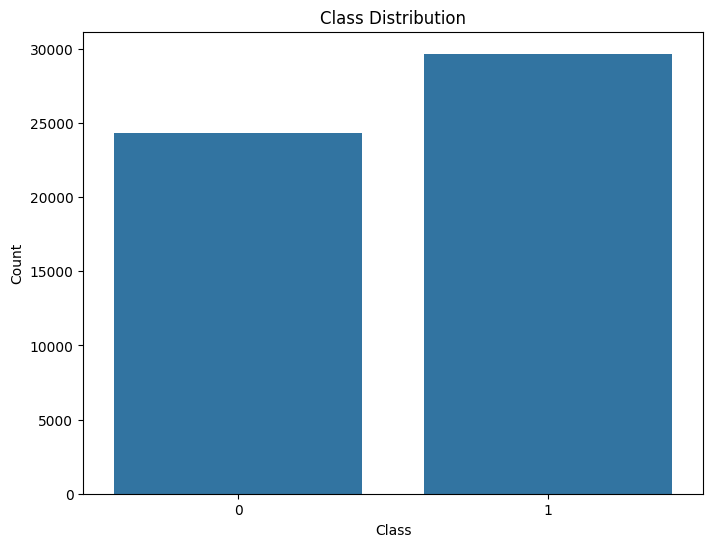

In [6]:
target_column = "class"  
class_counts = data[target_column].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

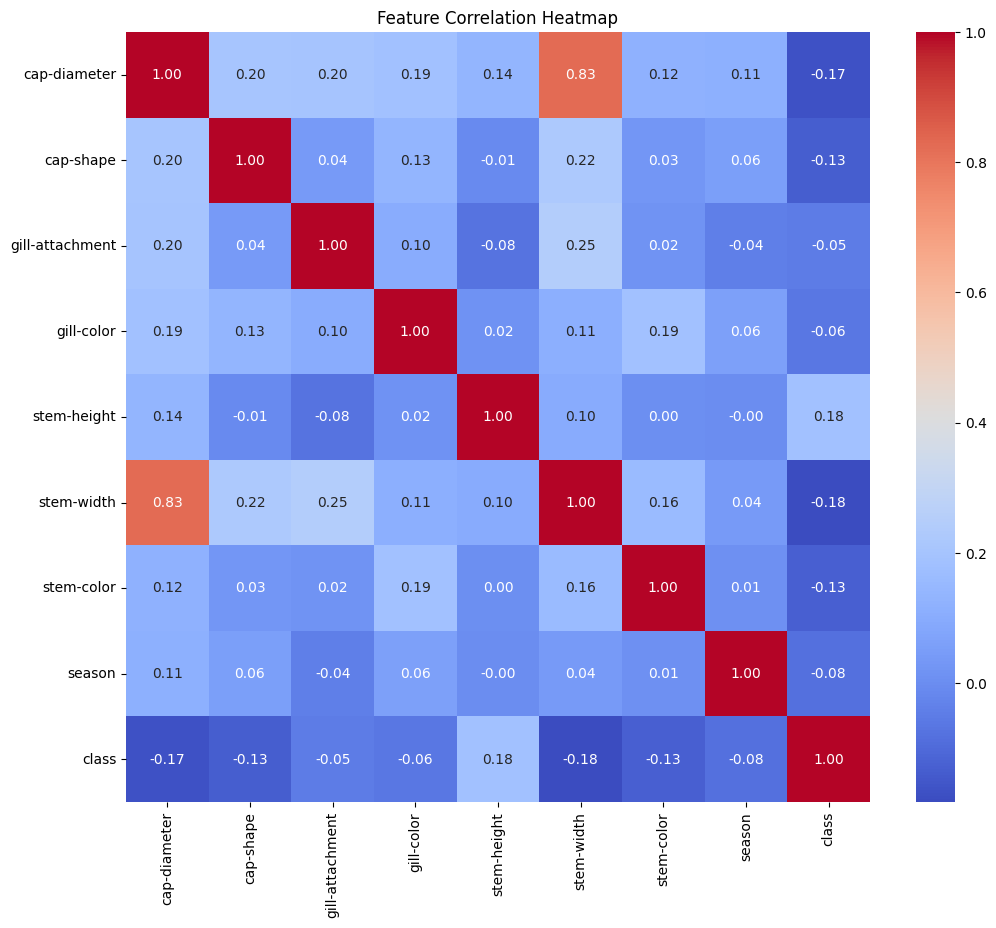

In [7]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = data.drop(columns=[target_column])
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
import dagshub
dagshub.init(repo_owner='AhmadMaraqa20', repo_name='Mlflow_Dagshub', mlflow=True)

Accessing as AhmadMaraqa20

Initialized MLflow to track repo "AhmadMaraqa20/Mlflow_Dagshub"

Repository AhmadMaraqa20/Mlflow_Dagshub initialized!

In [10]:

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=200),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=42),
}
model_name_to_id = {"RandomForest": 0, "LogisticRegression": 1, "KNeighbors": 2, "DecisionTree": 3}

mlflow.set_experiment("Model_Comparison_Experiment")
# mlflow.set_tracking_uri("http://localhost:5000") # for local mlflow
mlflow.set_tracking_uri("https://dagshub.com/AhmadMaraqa20/Mlflow_Dagshub.mlflow") # taken from   MLflow Tracking remote:

# Ideally you will not require following 4 lines if you have started fresh and do not have any previous dagshub credentials on your computer
# so u use the above line unless an error occurs
import os
# os.environ['MLFLOW_TRACKING_USERNAME'] = 'AhmadMaraqa20' 
# os.environ['MLFLOW_TRACKING_PASSWORD'] = '' #taken from    Public Key ID and Secret Access Key: 
# os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/AhmadMaraqa20/Mlflow_Dagshub.mlflow' #your dagshub unique uri   taken from   MLflow Tracking remote:

#after runnung code press in remote  -> go to mlflow ui


for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mlflow.log_param("model", model_name)
        
        report = classification_report(y_test, y_pred, output_dict=True)
        for metric, values in report.items():
            if isinstance(values, dict):  # For class-specific metrics
                for sub_metric, value in values.items():
                    mlflow.log_metric(f"{metric}_{sub_metric}", value)
            else:  # For overall metrics like accuracy
                mlflow.log_metric(metric, values)

        params = model.get_params()
        for param_name, param_value in params.items():
            mlflow.log_param(param_name, param_value)

        
        mlflow.log_metric("model_id", model_name_to_id[model_name])
        mlflow.set_tag("model_name", model_name)

        mlflow.sklearn.log_model(model, artifact_path="models")

        report_df = pd.DataFrame(report).transpose()
        report_path = f"classification_reports/{model_name}_classification_report.csv"
        report_df.to_csv(report_path, index=True)
        # mlflow.log_artifact(report_path)

        print(f"Successfully logged model: {model_name}")

print("All models trained and logged successfully!")

2025/01/11 23:43:37 INFO mlflow.tracking.fluent: Experiment with name 'Model_Comparison_Experiment' does not exist. Creating a new experiment.
2025/01/11 23:44:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Successfully logged model: RandomForest
🏃 View run RandomForest at: https://dagshub.com/AhmadMaraqa20/Mlflow_Dagshub.mlflow/#/experiments/0/runs/bb5da6a8a3ec4e119308b3966aedeb52
🧪 View experiment at: https://dagshub.com/AhmadMaraqa20/Mlflow_Dagshub.mlflow/#/experiments/0


d:\Qafza\6\Mlflow_Dagshub\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/01/11 23:45:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Successfully logged model: LogisticRegression
🏃 View run LogisticRegression at: https://dagshub.com/AhmadMaraqa20/Mlflow_Dagshub.mlflow/#/experiments/0/runs/b36c1120828e4edda0affc3ae8227d03
🧪 View experiment at: https://dagshub.com/AhmadMaraqa20/Mlflow_Dagshub.mlflow/#/experiments/0


2025/01/11 23:46:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Successfully logged model: KNeighbors
🏃 View run KNeighbors at: https://dagshub.com/AhmadMaraqa20/Mlflow_Dagshub.mlflow/#/experiments/0/runs/4a0b23e1b08b46bcb3123c4d0ab778fd
🧪 View experiment at: https://dagshub.com/AhmadMaraqa20/Mlflow_Dagshub.mlflow/#/experiments/0


2025/01/11 23:47:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Successfully logged model: DecisionTree
🏃 View run DecisionTree at: https://dagshub.com/AhmadMaraqa20/Mlflow_Dagshub.mlflow/#/experiments/0/runs/8397d837326f4de682daabe22451ec88
🧪 View experiment at: https://dagshub.com/AhmadMaraqa20/Mlflow_Dagshub.mlflow/#/experiments/0
All models trained and logged successfully!


In [ ]:
# to register model  (after i saw all results i choose to register the random forest model)
#1- from the local mflow -> this worked


#2- by api  -> it didnt work with me
# model_name = 'RandomForest'
# run_id=input('Please type RunID')
# model_uri = f'runs:/{run_id}/model_name'

# with mlflow.start_run(run_id=run_id):
#     mlflow.register_model(model_uri=model_uri, name=model_name)
#if u ran the cell one more time it will create version 2 of it and u can compare them



# 3-
# with mlflow.start_run() as run:
#     X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=42
#     )
#     params = {"max_depth": 2, "random_state": 42}
#     model = RandomForestRegressor(**params)
#     model.fit(X_train, y_train)

#     # Infer the model signature
#     y_pred = model.predict(X_test)
#     signature = infer_signature(X_test, y_pred)

#     # Log parameters and metrics using the MLflow APIs
#     mlflow.log_params(params)
#     mlflow.log_metrics({"mse": mean_squared_error(y_test, y_pred)})

#     # Log the sklearn model
# 
# and register as version 1
#     mlflow.sklearn.log_model(
#         sk_model=model,
#         artifact_path="sklearn-model",
#         signature=signature,
#         registered_model_name="sk-learn-random-forest-reg-model",)

In [10]:
# when register , you can add alias -> usually for deployed in production its name is champion , and here its challenger

In [12]:
#load our registered model
model_version = 1
model_name = 'RandomForest'
model_uri = f"models:/{model_name}/{model_version}"
loaded_model = mlflow.sklearn.load_model(model_uri)

y_pred = loaded_model.predict(X_test)  
print(y_pred[:4])  

[0 1 0 0]


In [17]:
#load our registered model
model_version = 1
model_uri = f"models:/{model_name}@challenger"
loaded_model = mlflow.sklearn.load_model(model_uri)

#test by our loaded model
y_pred = loaded_model.predict(X_test)
y_pred[:4]

array([0, 1, 0, 0])

In [ ]:
#test by our loaded model on test data  (offline evaluation)
y_pred = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4909
           1       0.99      0.99      0.99      5898

    accuracy                           0.99     10807
   macro avg       0.99      0.99      0.99     10807
weighted avg       0.99      0.99      0.99     10807



In [14]:
#  Transition the Model to Production

current_model_uri = f"models:/{model_name}@challenger"
production_model_name = "RF-prod"

client = mlflow.MlflowClient()
client.copy_model_version(src_model_uri=current_model_uri, dst_name=production_model_name)

Successfully registered model 'RF-prod'.
Copied version '1' of model 'RandomForest' to version '1' of model 'RF-prod'.


<ModelVersion: aliases=[], creation_timestamp=1736628645978, current_stage='None', description='', last_updated_timestamp=1736628645978, name='RF-prod', run_id='bb5da6a8a3ec4e119308b3966aedeb52', run_link='', source='models:/RandomForest/1', status='READY', status_message='', tags={}, user_id='', version='1'>

In [15]:
# test in the prod
model_version = 1
prod_model_uri = f"models:/{production_model_name}@champion"

loaded_model = mlflow.sklearn.load_model(prod_model_uri)
y_pred = loaded_model.predict(X_test)
y_pred[:4]

array([0, 1, 0, 0])